# Train LTR Model

This notebook demonstrates how to (1) Train a simple pointwise LTR model using sklearn's Logistic Regression and (2) Upload the model to Solr/Fusion to be used for query-time ranking.

Before running this notebook, you need to have run `Feature Extraction.ipynb` to generate feature vectors first.

In [90]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from constants import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from helpers.solr_client import *
from helpers.fusion_client import *

solr = LTRSolrClient(COLLECTION_NAME)
signals_client = SignalsSolrClient(SIGNALS_COLLECTION_NAME, base_fq=SIGNALS_BASE_FQ)
fusion = FusionAPIClient('http://localhost:8764/api/apollo/apps/{}'.format(FUSION_APP_NAME))

## Load feature vectors into a Pandas DataFrame

In [92]:
from helpers.train import *

samples_df, feature_names = load_samples(FEATURE_VECTORS_PATH)

FEATURES_NON_SIGNALS = [fn for fn in feature_names if 'previous_click_queries' not in fn]
FEATURES_WITH_SIGNALS = feature_names

# Prep samples for training pointwise LTR model.
# 1. Downsample negative class
# 2. Split samples into train and test sets, in a date-aware manner
preprocess_samples(samples_df, feature_names)

samples_df.head()

Loaded samples from /tmp/feature_vectors
# samples per class:
0    477861
1      3989
Name: target, dtype: int64
29 queries with < 5 hits, removing from training set
train base recall: 0.7946999695400548
test  base recall: 0.8065458796025716


,query_id,date,query,doc_id,target,tfidf_text,tfidf_name,tfidf_longDescription,tfidf_shortDescription,tfidf_features_t,...,salesRankLongTerm,salesRankMediumTerm,salesRankShortTerm,customerReviewAverage,customerReviewCount,regularPrice,salePrice,is_test,is_train,sampled
0,f6be3032-3068-4130-988b-511d6f768407,1.320024e+09,lcd tv,2620821,0,4.85487,4.85487,0.000000,0.0,2.286049,...,2593.0,879.0,904.0,4.2,185.0,449.99,329.99,False,True,True
1,f6be3032-3068-4130-988b-511d6f768407,1.320024e+09,lcd tv,2138389,0,4.85487,4.85487,4.155197,0.0,0.000000,...,36151.0,28075.0,16394.0,3.5,70.0,549.99,549.99,False,True,False
2,f6be3032-3068-4130-988b-511d6f768407,1.320024e+09,lcd tv,2893174,1,4.85487,4.85487,8.566318,0.0,2.008006,...,876.0,572.0,782.0,4.3,204.0,329.99,329.99,False,True,True
3,f6be3032-3068-4130-988b-511d6f768407,1.320024e+09,lcd tv,1831054,0,4.85487,4.85487,3.512868,0.0,0.000000,...,2135.0,1814.0,2058.0,3.8,407.0,699.99,479.99,False,True,False
4,f6be3032-3068-4130-988b-511d6f768407,1.320024e+09,lcd tv,2047641,0,4.85487,4.85487,8.114106,0.0,0.000000,...,84141.0,102178.0,0.0,3.6,72.0,349.99,349.99,False,True,False


## Train models using Logistic Regression

Train a Logistic Regression with and without signals-based `previous_click_queries` feature and compare

In [93]:
from helpers.ltr_experiments import *
from sklearn.linear_model import LogisticRegression

EVALUATORS = [
    single_feature_sort_evaluator('baseline', 
                                  'Baseline OOTB Solr Ranking', 
                                  'tfidf_text'),
    
    sklearn_model_evaluator('logit_non_signal', 
                            'Logit, no signals',
                            LogisticRegression(), 
                            FEATURES_NON_SIGNALS,
                            lambda x: x.coef_[0],
                            zscore_normalize=True),
    
    sklearn_model_evaluator('logit_signal', 
                            'Logit, with signals',
                            LogisticRegression(), 
                            FEATURES_WITH_SIGNALS,
                            lambda x: x.coef_[0],
                            zscore_normalize=True)
]

results_collector = ExpResultsCollector(samples_df)
for evaluator in EVALUATORS:
    results_collector.collect_results(*evaluator(samples_df))

baseline                  0.074  0.113  0.145  0.172  0.193  0.209  0.230  0.241  0.257  0.272  (0.177318069013)
logit_non_signal          0.112  0.188  0.250  0.287  0.309  0.335  0.362  0.399  0.423  0.440  (0.268408060027)
logit_signal              0.146  0.227  0.292  0.332  0.363  0.387  0.413  0.432  0.455  0.471  (0.312585137281)


In [94]:
from IPython.display import display

all_results_df = results_collector.get_results().sort_values(1)
all_results_mrr_df = results_collector.get_results_mrr()

models_to_include = all_results_df.index.values

display(style_results_df(all_results_df.loc[models_to_include], "LTR model comparison, average test recall@k"))

,1,2,3,4,5,6,7,8,9,10
Baseline OOTB Solr Ranking,0.074,0.113,0.145,0.172,0.193,0.209,0.23,0.241,0.257,0.272
"Logit, no signals",0.112,0.188,0.25,0.287,0.309,0.335,0.362,0.399,0.423,0.44
"Logit, with signals",0.146,0.227,0.292,0.332,0.363,0.387,0.413,0.432,0.455,0.471


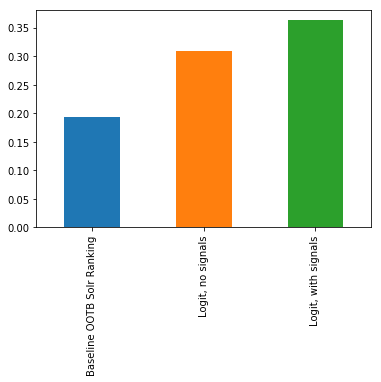

In [95]:
all_results_df[5].plot.bar()

# Upload model to Solr

In [84]:
clf = results_collector.results['logit_signal']['model']
params = {
    'weights': dict(zip(feature_names, clf.coef_[0]))
}

model_name = 'logit_001'
model_class = 'org.apache.solr.ltr.model.LinearModel'

feature_value_mean_train = samples_df[samples_df.is_train][list(feature_names)].mean()
feature_value_std_train = samples_df[samples_df.is_train][list(feature_names)].std()
features = []
for feature_name in feature_names:
    features.append({
        'name': feature_name,
        'norm': {
            'class': 'org.apache.solr.ltr.norm.StandardNormalizer',
            'params' : {
                'avg': str(feature_value_mean_train[feature_name]),
                'std': str(feature_value_std_train[feature_name])
            }
        }
    })

model = {
    'store': FEATURE_STORE_NAME,
    'name': model_name,
    'class': 'org.apache.solr.ltr.model.LinearModel',
    'features': features,
    'params': params
}
    
solr.delete_model(model_name)
solr.upload_model(model)

{
    "params": {
        "weights": {
            "customerReviewCount": 0.169746961526296, 
            "tfidf_text": 0.2830296621808461, 
            "customerReviewAverage": 0.6888977778742726, 
            "tfidf_name": 0.2830296621808461, 
            "tfidf_features_t": -0.002355580401806307, 
            "regularPrice": 0.3376684956766356, 
            "tfidf_previous_click_queries": 0.4288333119588699, 
            "tfidf_categoryNames_t": -0.04406873440252529, 
            "tfidf_longDescription": -0.19549477318325575, 
            "salesRankMediumTerm": 0.05549684071000778, 
            "salesRankLongTerm": -0.15507774850438344, 
            "salesRankShortTerm": -0.009798749117820181, 
            "tfidf_shortDescription": -0.1672777023605656, 
            "salePrice": -0.3151154725477539
        }
    }, 
    "features": [
        {
            "name": "tfidf_text", 
            "norm": {
                "params": {
                    "std": "4.922950999845654", 
        

{u'responseHeader': {u'QTime': 16, u'status': 0}}

## Enable query-time reranking

Follow instructions under `Update Fusion Query Pipeline to enable query-time reranking using trained LTR model` in README.md